In [1]:
from __future__ import print_function
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage
from IPython.display import SVG, display, clear_output
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('../../')
from retrosim.data.get_data import get_data_df, split_data_df
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage

import time

In [2]:
data = get_data_df('../data/data_processed.csv')

## Load general templates, which only include reaction core

In [3]:
with open('../data/templates_general.json', 'rb') as fid:
    templates = json.load(fid)
reactions = []
good_templates = []
counts = []
for template in templates:
    try:
        rxn = AllChem.ReactionFromSmarts(str(template))
        rxn.Initialize()
        [rct.UpdatePropertyCache() for rct in rxn.GetReactants()]
        [Chem.AssignStereochemistry(rct) for rct in rxn.GetReactants()]
        if rxn.Validate()[1] == 0:
            reactions.append(rxn)
            good_templates.append(template)
            counts.append(templates[template])
    except ValueError as e:
        pass
print('Loaded {} templates'.format(len(reactions)))

Loaded 1351 templates


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## What are the most common patterns of the sites of retro disconnections?

In [5]:
prod_templates = {}
for template in templates:
    prod = template.split('>>')[0]
    if prod == '([c;H0:1]-[n;H0:2](:[c;H0:3]):[cH:4]:[c;H0:5]:[c;H0:6])':
        print(template)
    if prod in prod_templates:
        prod_templates[prod] += templates[template]
    else:
        prod_templates[prod] = templates[template]
sorted_templates = sorted(prod_templates.items(), key = lambda x: x[1], reverse=True)
print('\n{} ........................ {}'.format(sorted_templates[:10], sorted_templates[-10:]))
print('num unique: {}'.format(len(prod_templates)))

with open('../data/templates_general_prods.json', 'w') as fid:
    json.dump(prod_templates, fid, indent=4)


[('([C;H0;+0:1]-[NH;+0:2])', 4941), ('([OH;+0:1])', 4085), ('([C;H0;+0:1]-[N;H0;+0:2])', 2433), ('([NH2;+0:1])', 2430), ('([c;H0;+0:1]-[c;H0;+0:2])', 2243), ('([CH2;+0:1]-[N;H0;+0:2])', 1943), ('([CH2;+0:1]-[O;H0;+0:2])', 1934), ('([NH;+0:1]-[c;H0;+0:2])', 1676), ('([N;H0;+0:1]-[c;H0;+0:2])', 1302), ('([NH;+0:1])', 1228)] ........................ [('([CH;+0:1]-[CH;@@;+0:2]-[OH;+0:3])', 1), ('([c;H0;+0:1]-[c;H0;+0:2](:[n;H0;+0:3]):[nH;+0:4]:[c;H0;+0:5])', 1), ('([CH2;+0:1]1-[CH2;+0:2]-[CH2;+0:3]-[NH;+0:4]-[CH2;+0:5]-[CH;+0:6]-1)', 1), ('([C;H0;+0:1]-[CH2;+0:2]-[CH;@@;+0:3])', 1), ('([CH2;+0:1]1-[CH;@;+0:2]-[CH2;+0:3]-[NH;+0:4]-[CH2;+0:5]-[CH;@;+0:6]-1)', 1), ('([BrH;+0:1])', 1), ('([c;H0;+0:1]:[c;H0;+0:2]:[c;H0;+0:3]:[n;H0;+0:4]-[c;H0;+0:5])', 1), ('([CH;@;+0:1]-[CH;@;+0:2])', 1), ('([CH3;+0:1]-[C;@;H0;+0:2]-[OH;+0:3])', 1), ('([CH;+0:1]=[CH;+0:2]\\[CH;@@;+0:3]-[CH;@;+0:4])', 1)]
num unique: 559


Text(0, 0.5, 'Number of precedents')

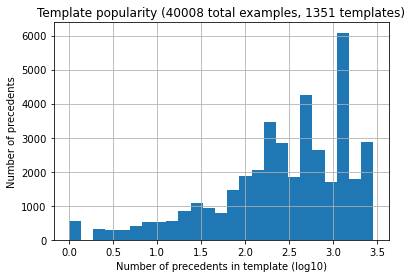

In [6]:
df = pd.DataFrame({'pop': [np.log10(x) for x in templates.values()]})
plot = df['pop'].hist(bins=25, weights=np.power(10.0, df['pop']))
plot.set_title("Template popularity ({} total examples, {} templates)".format(sum(templates.values()), len(templates)))
plot.set_xlabel("Number of precedents in template (log10)")
plot.set_ylabel("Number of precedents")

## How many unique precursors are there for a given disconnection?

Text(0, 0.5, 'Number of templates')

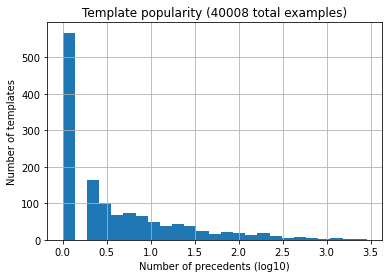

In [7]:
plot = df['pop'].hist(bins=25)
plot.set_title("Template popularity ({} total examples)".format(sum(templates.values())))
plot.set_xlabel("Number of precedents (log10)")
plot.set_ylabel("Number of templates")

In [8]:
prod_templates_unique = {}
ex_templates = {}
for template in templates:
    prod = template.split('>>')[0]
    if prod == '([c;H0:1]-[c;H0:2])':
        ex_templates[template] = templates[template]
    if prod in prod_templates_unique:
        prod_templates_unique[prod] += 1
    else:
        prod_templates_unique[prod] = 1
sorted_templates_unique = sorted(prod_templates_unique.items(), key = lambda x: x[1], reverse=True)
print('\n{} ........................ {}'.format(sorted_templates_unique[:10], sorted_templates_unique[-10:]))
print('num unique: {}'.format(len(prod_templates)))
with open('../data/templates_general_prods_unique_precursor_options.json', 'w') as fid:
    json.dump(prod_templates_unique, fid, indent=4)
with open('../data/templates_general_prods_unique_precursor_options_ex.json', 'w') as fid:
    json.dump(ex_templates, fid, indent=4)
print('Example for c-c disconnection:')
for (key, val) in sorted(ex_templates.items(), key = lambda x: x[1], reverse=True)[:10]:
    print('{} {}'.format(val, key))



[('([c;H0;+0:1]-[c;H0;+0:2])', 57), ('([C;H0;+0:1]-[c;H0;+0:2])', 53), ('([C;H0;+0:1]-[NH;+0:2])', 40), ('([CH;+0:1]-[c;H0;+0:2])', 31), ('([OH;+0:1])', 31), ('([CH2;+0:1]-[c;H0;+0:2])', 27), ('([C;H0;+0:1]-[N;H0;+0:2])', 27), ('([CH;+0:1]-[NH;+0:2])', 14), ('([NH2;+0:1])', 12), ('([N;H0;+0:1]-[c;H0;+0:2])', 12)] ........................ [('([BrH;+0:1])', 1), ('([c;H0;+0:1]:[c;H0;+0:2]:[c;H0;+0:3]:[n;H0;+0:4]-[c;H0;+0:5])', 1), ('([N;H0;+0:1]=[C;H0;+0:2]-[c;H0;+0:3])', 1), ('([NH2+:1])', 1), ('([CH;@;+0:1]-[CH;@;+0:2])', 1), ('([CH3;+0:1]-[C;@;H0;+0:2]-[OH;+0:3])', 1), ('([C;H0;+0:1]-[Cl;H0;+0:2])', 1), ('([c;H0;+0:1]-[c;H0;+0:2]1:[n;H0;+0:3]:[c;H0;+0:4]:[s;H0;+0:5]:[c;H0;+0:6]:1-[c;H0;+0:7])', 1), ('([CH;@;+0:1]-[CH2;+0:2]-[CH;@;+0:3])', 1), ('([CH;+0:1]=[CH;+0:2]\\[CH;@@;+0:3]-[CH;@;+0:4])', 1)]
num unique: 559
Example for c-c disconnection:


Text(0, 0.5, 'Number of unique disconnections')

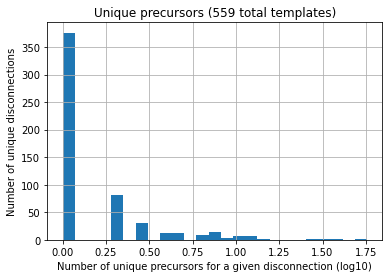

In [9]:
df = pd.DataFrame({'num': [np.log10(x) for x in prod_templates_unique.values()]})
plot = df['num'].hist(bins=25)
plot.set_title("Unique precursors ({} total templates)".format(len(prod_templates_unique)))
plot.set_xlabel("Number of unique precursors for a given disconnection (log10)")
plot.set_ylabel("Number of unique disconnections")

Text(0, 0.5, 'Number of unique templates')

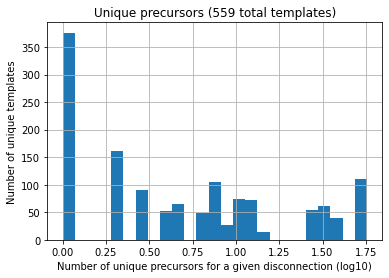

In [10]:
df = pd.DataFrame({'num': [np.log10(x) for x in prod_templates_unique.values()]})
plot = df['num'].hist(bins=25, weights=np.power(10.0, df['num']))
plot.set_title("Unique precursors ({} total templates)".format(len(prod_templates_unique)))
plot.set_xlabel("Number of unique precursors for a given disconnection (log10)")
plot.set_ylabel("Number of unique templates")

## What is the largest fragment that determines a retro disconnection?

In [11]:
num_atoms = {}
for template in templates:
    num = template.split('>>')[0].count('[')
    if num in num_atoms:
        num_atoms[num] += 1
    else:
        num_atoms[num] = 1
sorted_num_atoms = sorted(num_atoms.items(), key = lambda x: x[0])
print('List of (# atoms, # templates)')
print(sorted_num_atoms)

num_atoms = {}
for template in templates:
    num = template.split('>>')[0].count('[')
    if num in num_atoms:
        num_atoms[num] += templates[template]
    else:
        num_atoms[num] = templates[template]
sorted_num_atoms = sorted(num_atoms.items(), key = lambda x: x[0])
print('List of (# atoms, # training examples)')
print(sorted_num_atoms)

List of (# atoms, # templates)
[(1, 109), (2, 667), (3, 284), (4, 88), (5, 77), (6, 90), (7, 30), (8, 1), (11, 2), (13, 1), (15, 1), (19, 1)]
List of (# atoms, # training examples)
[(1, 8708), (2, 28970), (3, 1576), (4, 223), (5, 206), (6, 241), (7, 78), (8, 1), (11, 2), (13, 1), (15, 1), (19, 1)]


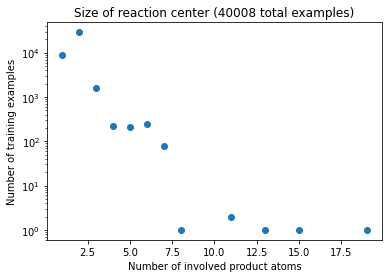

In [12]:
plot = plt.scatter(num_atoms.keys(), num_atoms.values())
plt.title("Size of reaction center ({} total examples)".format(sum(num_atoms.values())))
plt.xlabel("Number of involved product atoms")
plt.ylabel("Number of training examples")
plt.yscale('log')